In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# 선형회귀

## 정규 방정식

In [4]:
import numpy as np

np.random.seed(42)
# 샘플 갯수
m = 100                                 
# 열 벡터 mX1
X = 2 * np.random.rand(m, 1)
# 열 백터 mX1
y = 4 + 3 * X + np.random.randn(m ,1)

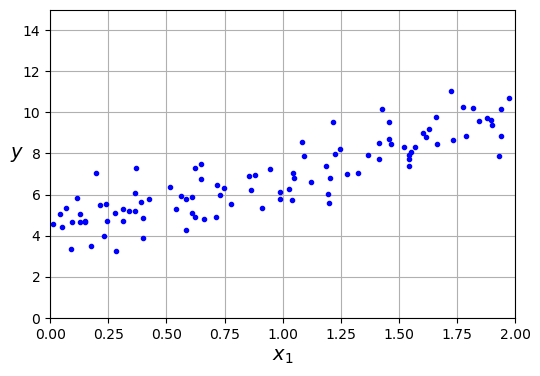

In [6]:
# 추가 코드 - 그림 4-1

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.show()

In [8]:
from sklearn.preprocessing import add_dummy_feature

# 각 샘플에 x0 = 1을 추가한다.
X_b = add_dummy_feature(X)
# 행렬 곱셈 : A @ B == np.matmul(A, B)
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

In [9]:
theta_best

array([[4.21509616],
       [2.77011339]])

In [11]:
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new)
y_pred = X_new_b @ theta_best
y_pred

array([[4.21509616],
       [9.75532293]])

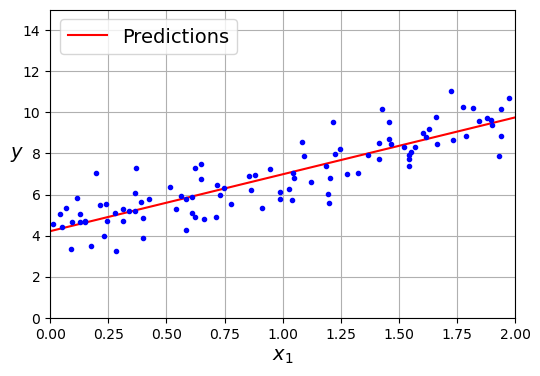

In [13]:
# 추가코드 - 그림 4-2

plt.figure(figsize=(6, 4))
plt.plot(X_new, y_pred, "r-", label="Predictions")
plt.plot(X, y, "b.")

plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.legend(loc="upper left")
plt.show()

In [14]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [15]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

In [16]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

In [17]:
np.linalg.pinv(X_b) @ y

array([[4.21509616],
       [2.77011339]])

# 경사 하강법

## 배치 경사 하강법

In [20]:
# 학습률
eta = 0.1
n_epochs = 1000
# 샘플 개수
m = len(X_b)

np.random.seed(42)
# 모델 파라미터를 랜덤 초기화한다.
theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    grad = 2 / m * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * grad

In [21]:
theta

array([[4.21509616],
       [2.77011339]])

In [22]:
# 추가 코드 - 그림 4-8
import matplotlib as mpl

def plot_gradient_descent(theta, eta):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_epochs = 1000
    n_shown = 20
    theta_path = []
    
    for epoch in range(n_epochs):
        if epoch < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(epoch / n_shown + 0.15))
            plt.plot(X_new, y_predict, linestyle="solid", color=color)
        gradients = 2 / m * X_b.T @ (X_b @ theta - y)
        theta = theta - eta * gradients
        theta_path.append(theta)
    
    plt.xlabel("$x_1$")
    plt.axis([0, 2, 0, 15])
    plt.grid()
    plt.title(fr"$\eta = {eta}$")
    
    return theta_path    

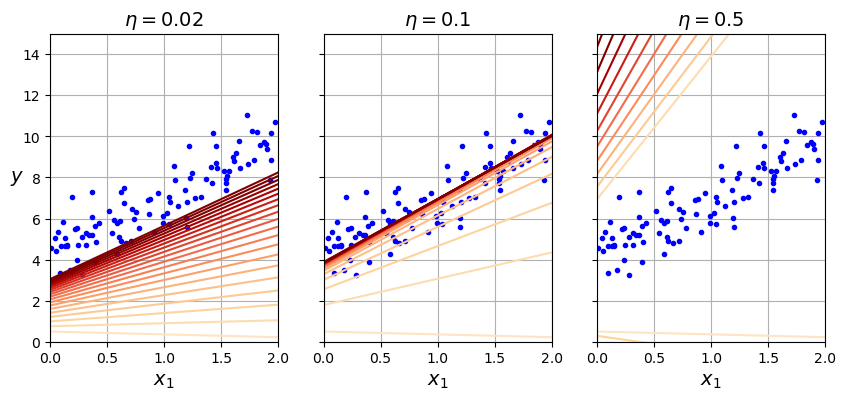

In [26]:
np.random.seed(42)
# 랜덤 초기화
theta = np.random.randn(2, 1)

plt.figure(figsize=(10, 4))
plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0)

plt.subplot(132)
theta_path_bgd = plot_gradient_descent(theta, eta=0.1)
plt.gca().axes.yaxis.set_ticklabels([])

plt.subplot(133)
plot_gradient_descent(theta, eta=0.5)
plt.gca().axes.yaxis.set_ticklabels([])

plt.show()

## 확률적 경사 하강법

In [27]:
theta_path_sgd = []  # 추가 코드 - 다음 그림을 그리기 위해 매개변수 공간에서 theta의 경로를 저장합니다.

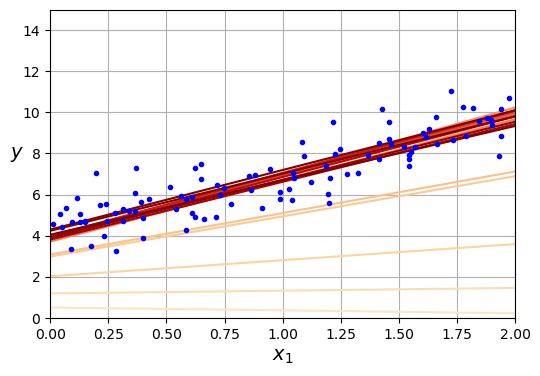

In [29]:
n_epochs = 50
# 학습 스케쥴 하이퍼파라미터
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t + t1)

np.random.seed(42)
theta = np.random.randn(2, 1)

# 추가 코드
n_shown = 20
plt.figure(figsize=(6, 4))

for epoch in range(n_epochs):
    # 매 에포크마다 모든 훈련 샘플을 사용한다.
    for iteration in range(m):
        # 추가 코드 - 그림을 생성하는 데 사용된다.
        if epoch == 0 and iteration < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(iteration / n_shown + 0.15))
            plt.plot(X_new, y_predict, color=color)
        
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index + 1]
        yi = y[random_index:random_index + 1]
        # SGD의 경우 m으로 나누지 않는다.
        gradients = 2 * xi.T @ (xi @ theta - yi)
        
        # 에포크가 반복될 때마다 t의 값이 선형적으로 증가되어
        # 학습률이 점진적으로 감소시키는 학습률 스케쥴
        # 매 에포크마다 동일하게 모든 훈련 샘플을 사용하기 때문에
        # 매 에포크마다 다른 학습률을 결정하는 것이 맞다. 
        # 그래서 t값을 계산할 때 epoch 변수를 사용하는 것이다.
        eta = learning_schedule(epoch * m + iteration)
        
        theta = theta - eta * gradients
        # 추가 코드 - 그림을 생성하기 위해
        theta_path_sgd.append(theta)
        
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.show()

In [30]:
theta

array([[4.21076011],
       [2.74856079]])

In [34]:
from sklearn.linear_model import SGDRegressor

# 최대 1,000번 에포크동안 실행되거나
# 100번 에포크 동안 손실이 1e-5보다 작아질 때까지 실행된다.
# 이 때, 학습률은 0.01이고 기본 학습 스케쥴을 사용한다.
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01,
                       n_iter_no_change=100, random_state=42)
# fit()이 1D 타깃을 기대하기 때문에 y.ravel()로 씁니다
sgd_reg.fit(X, y.ravel())

SGDRegressor(n_iter_no_change=100, penalty=None, random_state=42, tol=1e-05)

In [35]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21278812]), array([2.77270267]))

## 미니배치 경사 하강법

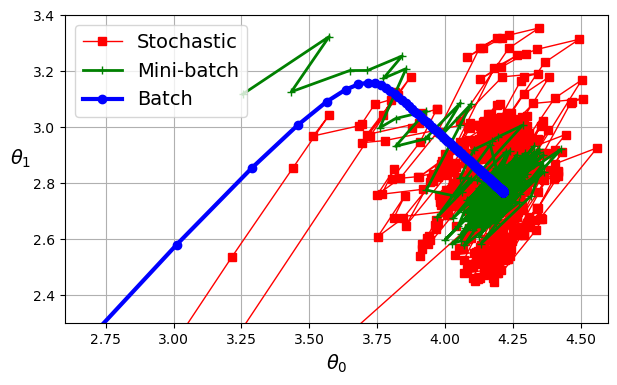

In [36]:
# 추가 코드 - 그림 4-11

from math import ceil

n_epochs = 50
minibatch_size = 20
n_batches_per_epoch = ceil(m / minibatch_size)

np.random.seed(42)
theta = np.random.randn(2, 1)

# 학습 스케쥴 하이퍼파라미터
t0, t1 = 200, 1000

def learning_schedule(t):
    return t0 / (t + t1)

theta_path_mgd = []
for epoch in range(n_epochs):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    
    for iteration in range(0, n_batches_per_epoch):
        idx = iteration * minibatch_size
        xi = X_b_shuffled[idx:idx + minibatch_size]
        yi = y_shuffled[idx:idx + minibatch_size]
        gradients = 2 / minibatch_size * xi.T @ (xi @ theta - yi)
        
        # 현재 미니배치에 있는 데이터를 순회할 때마다 
        # 학습률이 점진적으로 감소되는 학습률 스케쥴
        # 모든 미니배치는 이전 미니배치와 동일한 학습률로 처리돼야 한다.
        # 즉, 에포크에 상관없이 학습률이 계산돼야 한다.
        eta = learning_schedule(iteration)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

plt.figure(figsize=(7, 4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1,
         label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2,
         label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3,
         label="Batch")
plt.legend(loc="upper left")
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$   ", rotation=0)
plt.axis([2.6, 4.6, 2.3, 3.4])
plt.grid()
plt.show()